# USGS Catalogue

We can also track earthquakes that occur nearby the cables so that we can see if noise from the event is picked up by the cables in any way.
First we gather the earthquake data and then we plot the earthquakes locations along with their timing and intensity which is reflected in the size of the square in the plot.

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates
from datetime import datetime
from pyproj import Proj
import glob
import scipy.io
import datetime as dt
import h5py
from scipy.signal import butter, lfilter,filtfilt

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from scipy.signal import butter, lfilter

def applyCosineTaper(Data,TaperLength=20):

    numberOfSamples = Data.shape[-1]
    taper           = np.sin(0.5*np.pi*np.arange(0,TaperLength)/(TaperLength-1))

    window     = np.ones(numberOfSamples)
    window[0:TaperLength] = taper
    window[-TaperLength:] = taper[::-1]

    return Data*window

def butter_bandpass(lowcut, highcut, fs, order=5):
    
    if lowcut <= 0:
        return butter(order, highcut, fs=fs, btype='low', analog=False)
    else:
        return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def ReadHdf5File(Filename,Start=0,Stop=-1,Step=1):

    header={}
    header['SamplingFrequency[Hz]'] = -999
    header['SpatialResolution[m]' ] = -999
    header['Start Distance (m)'   ] = -999
    header['Stop Distance (m)'    ] = -999
    header['MeasureLength[m]'     ] = -999
    header['GaugeLength'          ] = -999
    
    with h5py.File(Filename, "r") as fp:
 
        rawData = np.array(fp['Acquisition']['Raw[0]']['RawData'][Start:Stop:Step,:])
    
        samplingFrequency = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
        
        gaugeLength     = Filename[Filename.rfind('-GL')+3:
                                   Filename.rfind('m-SP')]
        spatialSampling = Filename[Filename.rfind('-SP')+3:
                                   Filename.rfind('m-FS')]
        
        header['SamplingFrequency[Hz]'] = samplingFrequency
        header['SpatialResolution[m]' ] = spatialSampling
        header['GaugeLength'          ] = gaugeLength

    return rawData,header

In [3]:
%matplotlib inline 

# Earthquake examples

Here we have 2 examples of h5 files which contain earthquake event data that we are able to clearly visualise.

../../data/Earthquakes/Original\nc73647855_2.45_North-C3-HF-P1kHz-GL30m-Sp2m_2021-11-02T150445Z.h5


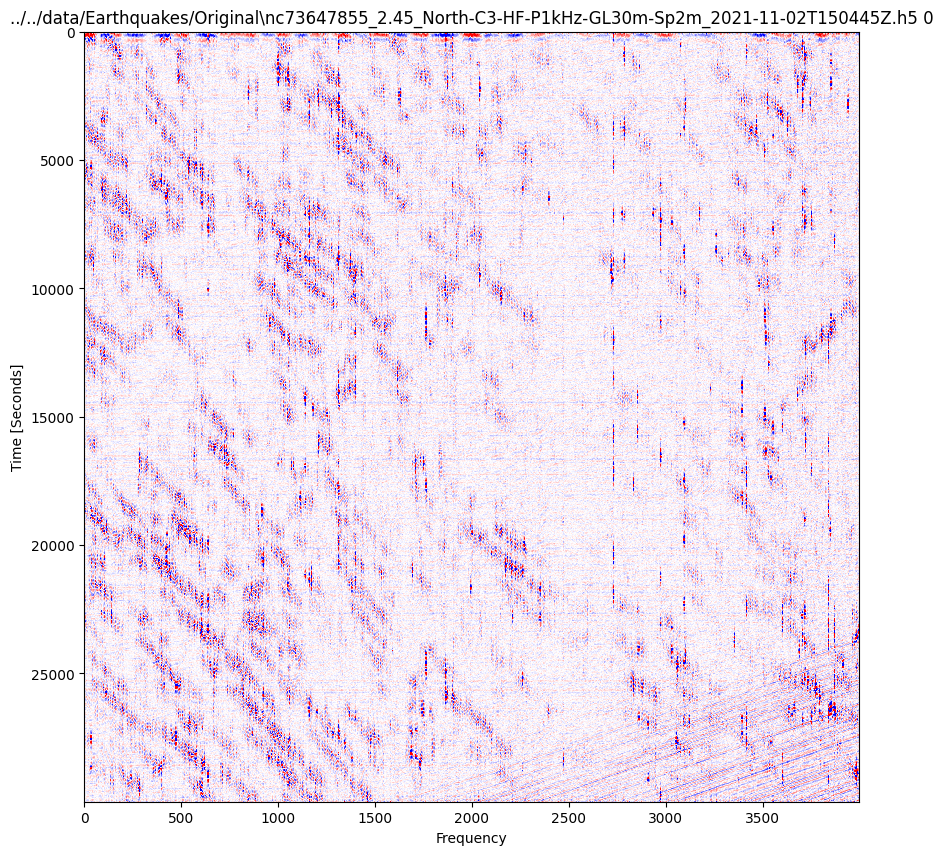

../../data/Earthquakes/Original\nc73647855_2.45_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T150514Z.h5


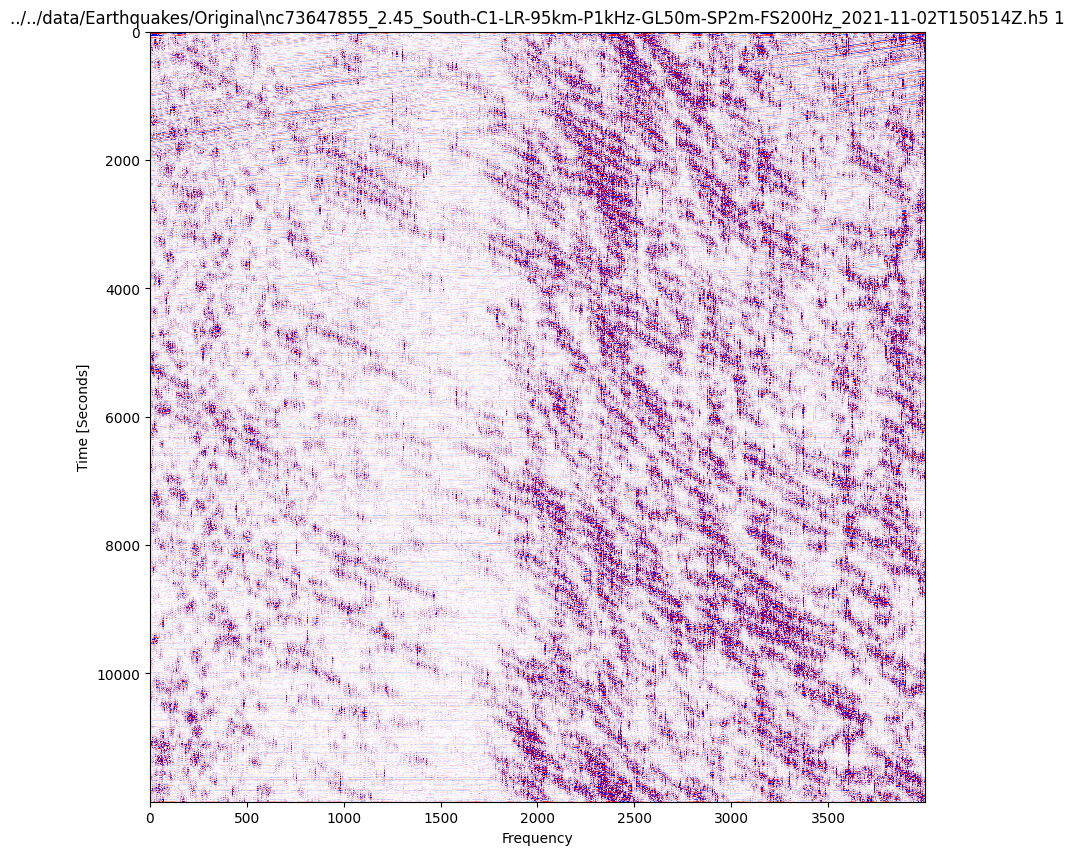

In [4]:
vMax = -999
files = sorted(glob.glob(r'../../data/Earthquakes/Original/nc*_2021-11-02T*.h5'))
for i,file in enumerate(files):
    
    print(file)
    acousticData,header = ReadHdf5File(file,24000,32000,2)
    fs = header['SamplingFrequency[Hz]']

    fdata = butter_highpass_filter(acousticData[:,:], 2.5, fs, order=5)

    #fdata  = butter_bandpass_filter(, 2, 50, 200, taper=True,order=5)
    #fdata -=fdata.mean(0)
    #fdata  = (fdata.T / np.abs(fdata).max(1)).T
    #fdata  = block_reduce(np.abs(fdata),(10,5),func=np.mean)

    if vMax < 0:
        vMax = np.percentile(fdata,85.0)
        
    plt.figure(figsize=(10,10))
    plt.imshow(fdata[:,:].T,aspect='auto',vmax=vMax,vmin=-vMax,cmap='bwr')
    plt.title(file+' '+str(i))
    plt.xlabel('Frequency')
    plt.ylabel('Time [Seconds]')

    plt.show()
    #plt.savefig(file[0:-3]+'.png')
    #plt.close()

# A zoomed in look

In this example we take a portion of the 2nd file and zoom in to get a better look at what the earthquake events can look like

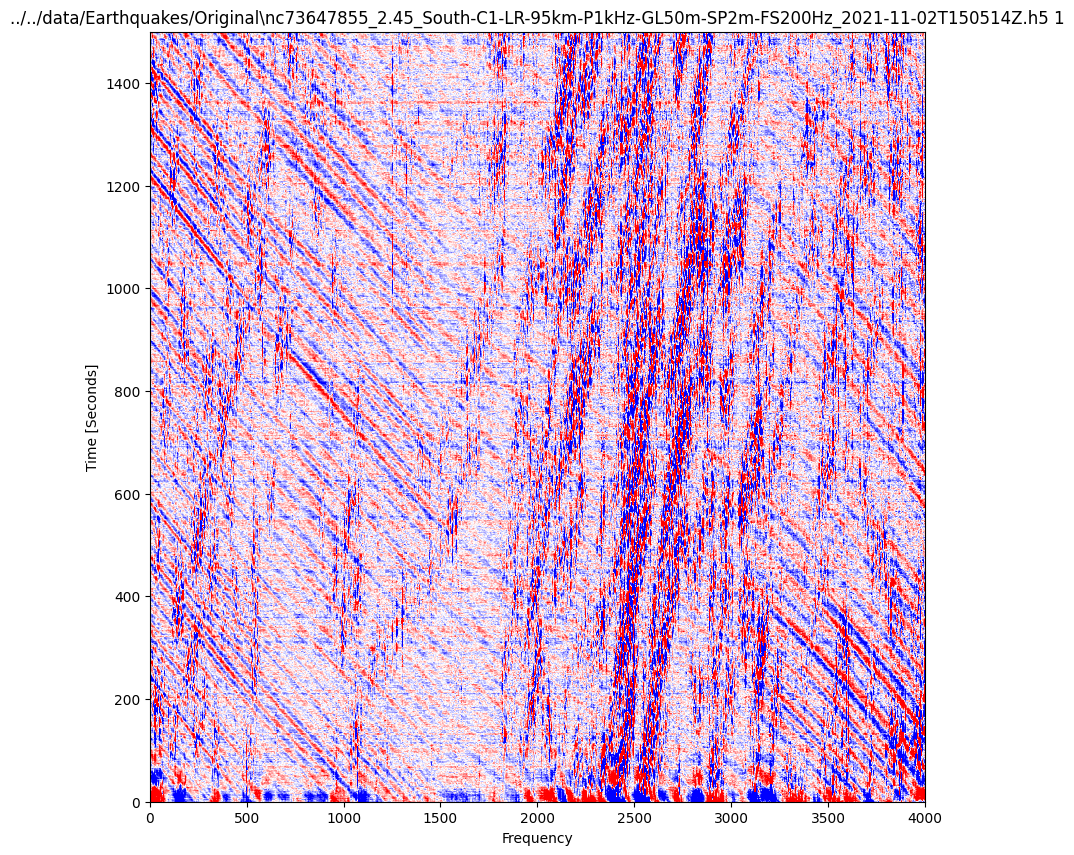

In [7]:

    plt.figure(figsize=(10,10))
    plt.imshow(fdata[:,:].T,aspect='auto',vmax=vMax,vmin=-vMax,cmap='bwr')
    plt.title(file+' '+str(i))
    plt.xlim(0,4000);
    plt.ylim(0,1500);
    plt.xlabel('Frequency')
    plt.ylabel('Time [Seconds]')

    plt.show()

# Plotting Earthquake events

Here we setup all of the data we need to begin plotting earthquake events in a few different ways.

In [11]:
myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

df_AisTypes = pd.read_csv(r'../../Documentation/AisData/AisVesselTypes.csv')

AisFilename = r'../../Documentation/AisData/AIS_167528271268456143_461-1675282713663.csv'
df_Ais = pd.read_csv(AisFilename) 
df_Ais['DateTimeUTC'] = pd.to_datetime(df_Ais['BaseDateTime'])

x,y = myProj(df_Ais['LON'].values, df_Ais['LAT'].values)
df_Ais['Easting' ] = x
df_Ais['Northing'] = y

df_Ais['Type'] = [df_AisTypes[str(t)].values[0] for t in df_Ais['VesselType'].values]

df_Ais.to_csv(AisFilename)

df_SouthCable= pd.read_csv(r'../../Documentation/CableGeometries/SouthCable_Geometry.csv')
df_SouthCable.describe()

df_NorthCable= pd.read_csv(r'../../Documentation/CableGeometries/NorthCable_Geometry.csv')
df_NorthCable.describe()

Unnamed: 0.1    Unnamed: 0       Station        Length        Easting  \
count  31518.000000  31518.000000  31518.000000  31518.000000   31518.000000   
mean   15758.500000  15758.500000  16700.500000      2.044761  392732.227387   
std     9098.607229   9098.607229   9098.607229      0.365958   17886.641355   
min        0.000000      0.000000    942.000000      0.000000  362576.157128   
25%     7879.250000   7879.250000   8821.250000      1.665085  377188.082131   
50%    15758.500000  15758.500000  16700.500000      2.059680  392591.716051   
75%    23637.750000  23637.750000  24579.750000      2.397917  408111.701758   
max    31517.000000  31517.000000  32459.000000      2.706210  424042.519241   

           Northing           LON           LAT         Depth  
count  3.151800e+04  31518.000000  31518.000000  31518.000000  
mean   5.009304e+06   -124.366567     45.228820   -293.253889  
std    3.672371e+03      0.228542      0.030474    175.626116  
min    5.004869e+06   -124.751020     45.192674   -589.135670  
25%    5.005389e+06   -124.565425     45.196727   -457.766588  
50%    5.008829e+06   -124.368145     45.224756   -363.825470  
75%    5.012759e+06   -124.169817     45.257109   -126.949517  
max    5.015447e+06   -123.967150     45.280533     11.090885

In [12]:
myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

df_UsgsEq= pd.read_csv(r'../../Documentation/Catalogues/UsgsEarthquakeCatalogue.csv')

x,y = myProj(df_UsgsEq['LON'].values,
             df_UsgsEq['LAT'].values)
df_UsgsEq['Easting' ] = x
df_UsgsEq['Northing'] = y

df_UsgsEq.to_csv(r'../../Documentation/Catalogues/UsgsEarthquakeCatalogue.csv')

## Plotting earthquakes in relation to the cables

This example displays all the earthquake events that occur nearby the cables within a space of time, with the squares varying in size depending on their intensity.

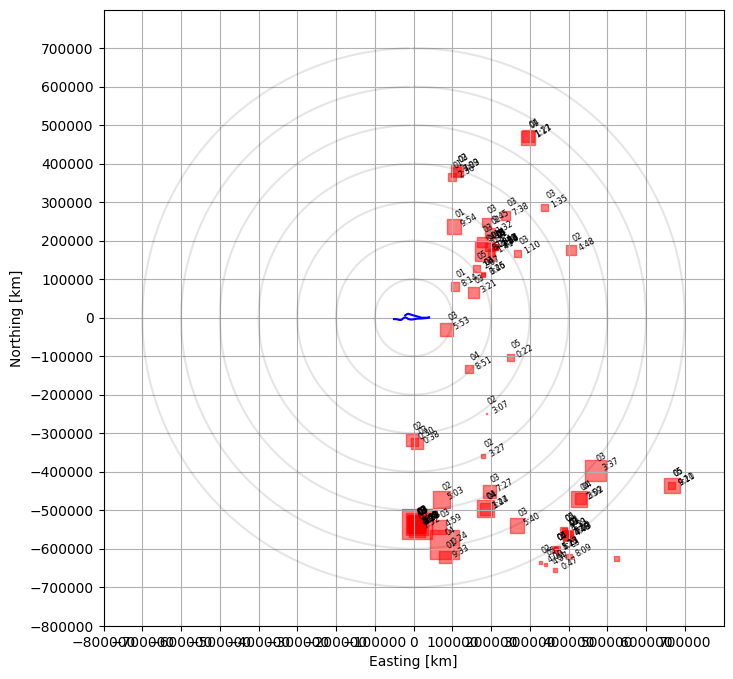

In [13]:

xc = np.mean(np.hstack([df_NorthCable['Easting'].values,df_SouthCable['Easting'].values]))
yc = np.mean(np.hstack([df_NorthCable['Northing'].values,df_SouthCable['Northing'].values]))

df_UsgsEq['DistanceToCable'] = np.hypot(x-xc,y-yc)

mask2 = (df_UsgsEq['DistanceToCable'] < 800*1e3) 

plt.figure(figsize=(8,8))

theta = np.deg2rad( np.arange(0,360,1) )
for r in range(100,800,100):
    plt.plot(r*1e3*np.sin(theta),
             r*1e3*np.cos(theta),'k-',alpha=0.1)

plt.plot(df_NorthCable['Easting'].values-xc,df_NorthCable['Northing']-yc,'b-')
plt.plot(df_SouthCable['Easting'].values-xc,df_SouthCable['Northing']-yc,'b-')
plt.scatter(x-xc,y-yc,s=(df_UsgsEq['mag']*5)**2,marker='s',color='r',alpha=0.5)

for i,dm in enumerate(zip(df_UsgsEq['DistanceToCable'][mask2],df_UsgsEq['mag'][mask2])):
    
    dateTime = df_UsgsEq['time'][mask2].values[i]
    dateTime = dateTime[8:10]+"\n"+dateTime[12:-8]
    plt.text(x[mask2][i]-xc,y[mask2][i]-yc,dateTime,fontsize='xx-small',rotation=30)

plt.xlim(-800e3,800e3)
plt.ylim(-800e3,800e3)
plt.grid()
plt.xticks(range(-800000,800000,100000))
plt.yticks(range(-800000,800000,100000))
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')

plt.show()


# Plot Timeline

Here we plot all of the earthquake events over a period of time split into graphs based on the distance from the cables.
The ones marked in red are earthquakes which occur during the specified range.

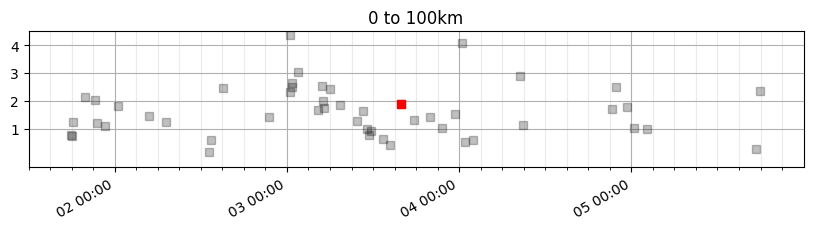

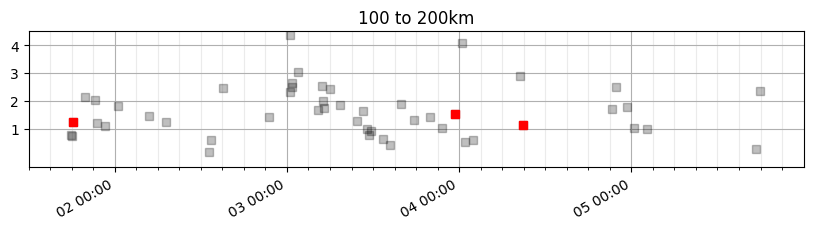

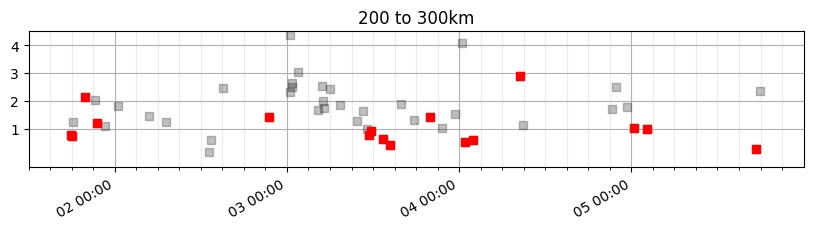

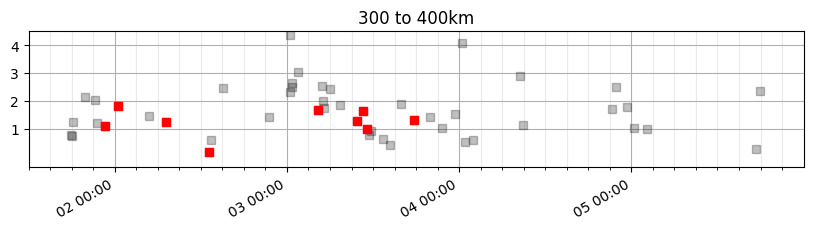

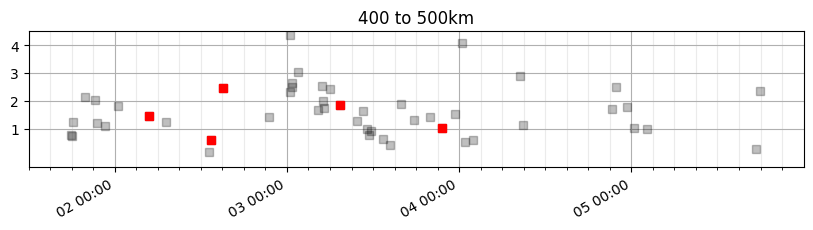

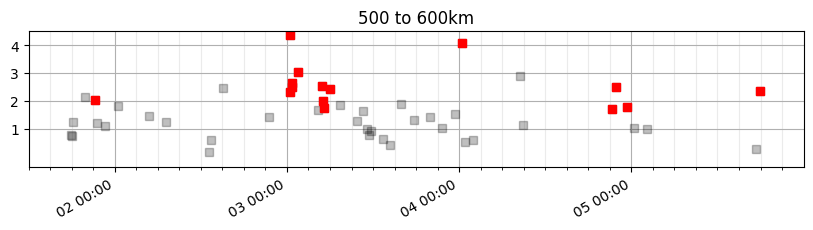

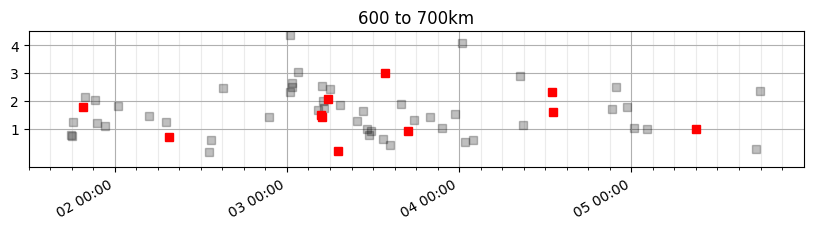

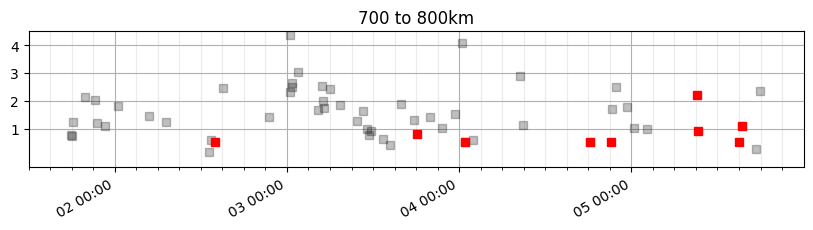

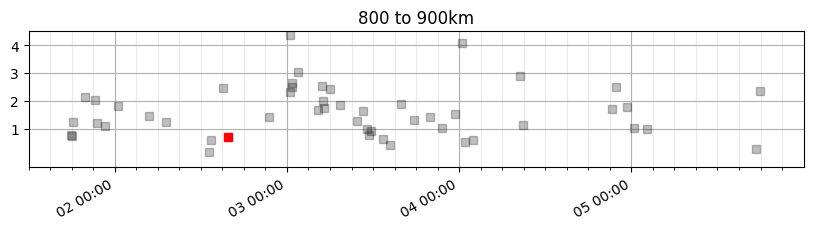

In [14]:
import matplotlib.dates as mdates

for d in [0,100,200,300,400,500,600,700,800]:
    
    mask = (df_UsgsEq['DistanceToCable'] >= d*1e3) & (df_UsgsEq['DistanceToCable'] < (d+100)*1e3)
    mask2 = (df_UsgsEq['DistanceToCable'] < 600*1e3) 
    df_UsgsEq['DateTimeObject'] =pd.to_datetime(df_UsgsEq['time'], format='%Y-%m-%d %H:%M:%S')

    plt.figure(figsize=(10,2))

    plt.plot(df_UsgsEq['DateTimeObject'][mask2],df_UsgsEq['mag'][mask2],'ks',alpha=0.25)
    plt.plot(df_UsgsEq['DateTimeObject'][mask ],df_UsgsEq['mag'][mask],'rs')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3))
    plt.gcf().autofmt_xdate()
    plt.xlim(mdates.date2num(datetime.strptime('20211101_120000','%Y%m%d_%H%M%S')),
             mdates.date2num(datetime.strptime('20211105_235959','%Y%m%d_%H%M%S')))
    plt.grid(which='major',alpha=1.00)
    plt.grid(which='minor',alpha=0.25)
    plt.yticks([1,2,3,4])
    plt.ylim(-0.4,4.5)
    plt.title(str(d)+' to '+str(d+100)+'km')
    plt.show()

## Plotting earthquake events based on distance and intensity

By plotting earthquake events on how close they are to the cable and their intensity, we can identify which ones may useful to look for in recordings as they may be more visible in the data.

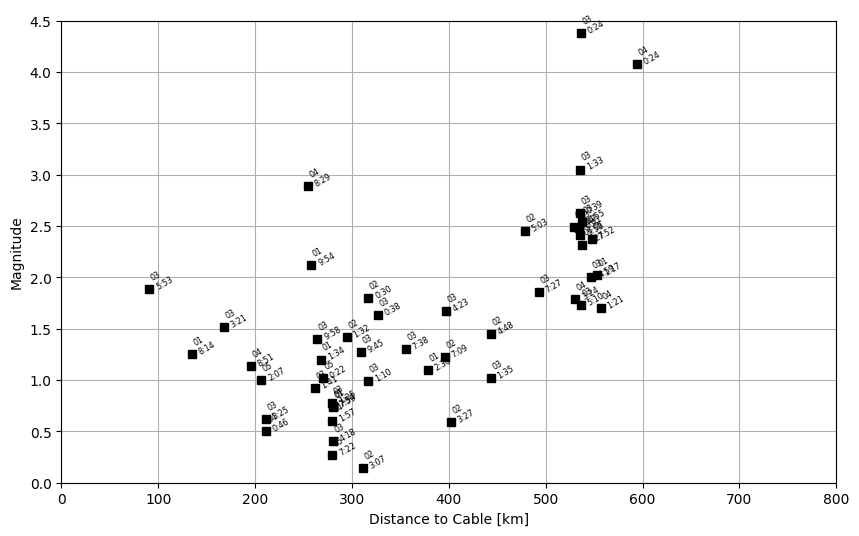

In [15]:
plt.figure(figsize=(10,6))
plt.plot(df_UsgsEq['DistanceToCable'][mask2]/1000,df_UsgsEq['mag'][mask2],'sk')
for i,dm in enumerate(zip(df_UsgsEq['DistanceToCable'][mask2]/1000,df_UsgsEq['mag'][mask2])):
    dateTime = df_UsgsEq['time'][mask2].values[i]
    dateTime = dateTime[8:10]+"\n"+dateTime[12:-8]
    plt.text(dm[0],dm[1],dateTime,fontsize='xx-small',rotation=30)
plt.xlabel('Distance to Cable [km]')
plt.ylabel('Magnitude')
plt.xlim(0,800)
plt.ylim(0,4.5)
plt.grid()
plt.show()